In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, 
                     random_mini_batches, 
                     convert_to_one_hot, 
                     predict

%matplotlib inline
np.random.seed(1)

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5


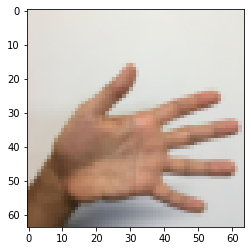

In [3]:
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

扁平化

In [4]:
x_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
x_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

归一化

In [9]:
X_train = x_train_flatten / 255
X_test = x_test_flatten / 255

one_hot编码

In [10]:
Y_train = convert_to_one_hot(Y_train_orig,6)
Y_test = convert_to_one_hot(Y_test_orig,6)

In [11]:
print("number of training examples = " + str(X_train.shape[1]))
print("number of test examples = " + str(X_test.shape[1]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


## 创建占位符

创建X和Y占位符，之后执行计算图时，就可以把训练集的数据填充到tensorflow计算图中

In [12]:
def create_placeholders(n_x, n_y):
    
    #样本数量的位置时None，因为执行训练时，用到的样本数量不同
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    
    return X, Y

单元测试

In [13]:
X, Y = create_placeholders(12288, 6)
print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(6, ?), dtype=float32)


## 初始化参数

In [16]:
def initialize_parameters():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable('W1', [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [25, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable('W2', [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [12, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable('W3', [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', [6, 1], initializer = tf.zeros_initializer())
    
    parameters = {
        "W1" : W1,
        "b1" : b1,
        "W2" : W2,
        "b2" : b2,
        "W3" : W3,
        "b3" : b3
    }
    
    return parameters

单元测试

In [18]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print("W3 = " + str(parameters["W3"]))
    print("b3 = " + str(parameters["b3"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(6, 12) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(6, 1) dtype=float32_ref>


## 实现前向传播

In [20]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

单元测试


In [21]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


## 计算成本

In [27]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

单元测试

In [28]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


## 反向传播

tensorflow框架，只需要一行代码就可以完成反向传播和参数更新了
只需要创建一个"optimizer" 可以指定梯度下降算法，还需指定学习率，还需要指定与哪个cost函数合作

## 构建完整的模型

In [32]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
              
    ops.reset_default_graph()# 将计算图返回到默认空状态
    tf.set_random_seed(1) 
    seed = 3      
    (n_x, m) = X_train.shape # (n_x: 特征数量, m : 训练集中的样本数)
    n_y = Y_train.shape[0] 
    costs = []   
    
    # 创建占位符
    X, Y = create_placeholders(n_x, n_y)

    # 初始化参数
    parameters = initialize_parameters()
    
    # 构建前向传播操作
    Z3 = forward_propagation(X, parameters)
    
    # 构建成本计算操作
    cost = compute_cost(Z3, Y)
    
    # 构建反向传播，为反向传播指定优化算法和学习率以及成本函数，这里我们使用adam算法，
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # 定义初始化操作
    init = tf.global_variables_initializer()

    # 开始一个tensorflow的session
    with tf.Session() as sess:
        
        # 执行初始化操作
        sess.run(init)
        
        # 执行epochs指定的训练次数，一个epoch就是完整的向整个数据集学习一次
        for epoch in range(num_epochs):

            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) # 计算有多少个子训练集
            seed = seed + 1
            # 将数据集分成若干子训练集
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            # 循环遍历每一个子训练集
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                # 这行代码会使整个计算图被执行，从前向传播操作到反向传播操作，最后到参数更新操作。
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                                
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # 画出cost成本的走势图
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # 从计算图中获取训练好了的参数，后面我们就可以用这些参数来识别手语了！
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # 分别计算一下在训练集和测试集上面的预测精准度
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.017255
Cost after epoch 200: 0.733184
Cost after epoch 300: 0.573071
Cost after epoch 400: 0.468573
Cost after epoch 500: 0.381228
Cost after epoch 600: 0.313815
Cost after epoch 700: 0.253708
Cost after epoch 800: 0.203900
Cost after epoch 900: 0.166453
Cost after epoch 1000: 0.146636
Cost after epoch 1100: 0.107279
Cost after epoch 1200: 0.086699
Cost after epoch 1300: 0.059341
Cost after epoch 1400: 0.052289


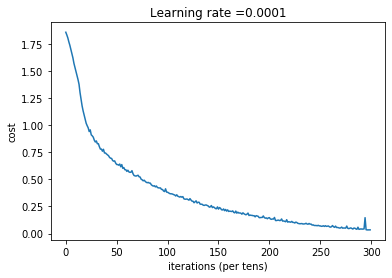

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.725


In [33]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [34]:
import scipy
from PIL import Image
from scipy import ndimage

my_image = "thumbs_up.jpg"

fname = "images/" + my_image
image = np.array(plt.imread(fname))
my_image = scipy.misc.imresize(image, size=(64, 64)).reshape((1, 64 * 64 * 3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

AttributeError: module 'scipy.misc' has no attribute 'imresize'